# Transaction Feature Extraction

In [88]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
from datetime import datetime

from ethereum import (
    timestamp_to_datetime,
    EthereumData
)
from utils import (
    latest,
    lead_lag,
    add_latest_avail_block
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of ethereum failed: Traceback (most recent call last):
  File "/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
KeyboardInterrupt
]


In [111]:
#feature_block_lags = [10, 20, 50, 100]

In [2]:
dt = "2021-09-01"

eth_data = EthereumData(start_date=dt, end_date=dt, save_path=f"data/{dt}")

In [3]:
eth_data.load()

Loading blocks...
Loading transactions...
Loading contracts...
Loading logs...
Loading receipts...
Loading token_transfers...
Loading tokens...


In [4]:
clean_tx = eth_data.clean()

### Point in Time

In [7]:
#clean_tx.head()

In [6]:
pit = eth_data.point_in_time_blocks(lag=60)

In [14]:
pit.head(20)

,datetime,lag_cutoff,latest_avail_block
number,,,
13136427,2021-09-01 00:00:12,2021-08-31 23:59:12,NaN
13136428,2021-09-01 00:00:40,2021-08-31 23:59:40,NaN
13136429,2021-09-01 00:00:44,2021-08-31 23:59:44,NaN
13136430,2021-09-01 00:00:46,2021-08-31 23:59:46,NaN
13136431,2021-09-01 00:00:48,2021-08-31 23:59:48,NaN
13136432,2021-09-01 00:01:24,2021-09-01 00:00:24,13136427.0
13136433,2021-09-01 00:01:39,2021-09-01 00:00:39,13136427.0
13136434,2021-09-01 00:01:40,2021-09-01 00:00:40,13136427.0
13136435,2021-09-01 00:01:45,2021-09-01 00:00:45,13136429.0


In [19]:
eth_data.transactions.columns

Index(['hash', 'nonce', 'block_hash', 'block_number', 'transaction_index',
       'from_address', 'to_address', 'value', 'gas', 'gas_price', 'input',
       'block_timestamp', 'max_fee_per_gas', 'max_priority_fee_per_gas',
       'transaction_type'],
      dtype='object')

In [79]:
df = eth_data.receipts

In [80]:
df['is_vanilla'] = df['gas_used'] == 21000

In [43]:
pit['latest_avail_block']

number
13136427           NaN
13136428           NaN
13136429           NaN
13136430           NaN
13136431           NaN
               ...    
13142877    13142873.0
13142878    13142874.0
13142879    13142877.0
13142880    13142878.0
13142881    13142878.0
Name: latest_avail_block, Length: 6455, dtype: float64

In [82]:
df['transaction_id'] = df['block_number'].astype(str) + "_" + df['transaction_index'].astype(str)

In [83]:
cols = [
    'transaction_id', 'block_number', 'cumulative_gas_used', 'gas_used', 'status', 
    'effective_gas_price', 'is_vanilla'
]

In [84]:
df = df[cols].set_index('transaction_id')

In [86]:
def add_latest_avail_block(df, pit, block_number_col='block_number'):
    res = pd.merge(
        left=df, 
        right=pit[['latest_avail_block']],
        how='left',
        left_on=block_number_col,
        right_index=True
    )
    return res

In [87]:
add_latest_avail_block(df, pit)

,block_number,cumulative_gas_used,gas_used,status,effective_gas_price,is_vanilla,latest_avail_block
transaction_id,,,,,,,
13136829_200,13136829,13993863,67483,1,93889714585,False,13136824.0
13136829_201,13136829,14142764,148901,1,93889714585,False,13136824.0
13136829_202,13136829,14163764,21000,1,93615785860,True,13136824.0
13136829_203,13136829,14209909,46145,1,93615785860,False,13136824.0
13136829_204,13136829,14230909,21000,1,93615785860,True,13136824.0
...,...,...,...,...,...,...,...
13142526_119,13142526,10370053,21580,0,91981039498,False,13142518.0
13142526_120,13142526,11324660,954607,1,91981039498,False,13142518.0
13142526_121,13142526,11483160,158500,1,91981039498,False,13142518.0


In [89]:
df.groupby('block_number').mean()

[autoreload of ethereum failed: Traceback (most recent call last):
  File "/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
   

KeyboardInterrupt: 

In [40]:
blocks_receipts_vanilla

,is_vanilla
block_number,
13136427,0.282282
13136428,0.343284
13136429,0.222222
13136430,0.230769
13136431,0.276119
...,...
13142877,0.347107
13142878,0.349869
13142879,0.280000


In [38]:
#df['gas_used'] == 21000

In [17]:
eth_data.receipts.columns

Index(['transaction_hash', 'transaction_index', 'block_hash', 'block_number',
       'cumulative_gas_used', 'gas_used', 'contract_address', 'root', 'status',
       'effective_gas_price'],
      dtype='object')

In [ ]:
eth_data.
    

In [37]:
eth_data.transactions.head()

,hash,nonce,block_hash,block_number,transaction_index,from_address,to_address,value,gas,gas_price,input,block_timestamp,max_fee_per_gas,max_priority_fee_per_gas,transaction_type
0,0x0c7e291fbd6c6094c53e81b116cca1a5a0ad199c10aa...,783,0x71fecf94580b6bdc8184f6799a0506d80d4c0f2df75e...,13136827,0,0x5629eb360b54e146323f8aa34546796029bd78f6,0x0944d5848bd9f60a34ba92aea300d4286696eb76,0,70000,207438875866,0xa9059cbb000000000000000000000000a0a659cb8d05...,1630459818,NaN,NaN,0
1,0x2567f447d63b76de7fb59e6a36af0614f3cdd6fc1e68...,832716,0x71fecf94580b6bdc8184f6799a0506d80d4c0f2df75e...,13136827,1,0x1938a448d105d26c40a52a1bfe99b8ca7a745ad0,0xbb0e17ef65f82ab018d8edd776e8dd940327b28b,0,200000,193619607297,0xa9059cbb000000000000000000000000997fc8213681...,1630459818,NaN,NaN,0
2,0x03e5375d7ea8ea68d3c18dec32d75099a287cc232b42...,7304,0x71fecf94580b6bdc8184f6799a0506d80d4c0f2df75e...,13136827,2,0xbccec45297ec2877ba96ae86b2fe59f95a0522e6,0xe000af30955d5d1f539d6ab4dfc2df499cb4f5f7,189465600000000000,50000,163423700000,0x,1630459818,NaN,NaN,0
3,0x8a15f43c852136141e3417684284df785104adefa739...,199407,0x71fecf94580b6bdc8184f6799a0506d80d4c0f2df75e...,13136827,3,0x4ad64983349c49defe8d7a4686202d24b25d0ce8,0xe7703b16ef7cd803ff46703172ef402f07a0ebb2,51996000000000000,60000,139162548391,0x,1630459818,NaN,NaN,0
4,0x20126b157dc61a5ef2af7528b4e51aca6ee79ce983e1...,0,0x71fecf94580b6bdc8184f6799a0506d80d4c0f2df75e...,13136827,4,0xb6d0a541e1e94a037a2b3d5e998c1272227c7b92,0x4ad64983349c49defe8d7a4686202d24b25d0ce8,249587000000000000,21000,138000000000,0x,1630459818,NaN,NaN,0


In [12]:
eth_data.receipts.head()

,transaction_hash,transaction_index,block_hash,block_number,cumulative_gas_used,gas_used,contract_address,root,status,effective_gas_price
0,0xb73ba89e2711f11fa62132c2eebdc828e853700f04f8...,200,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,13136829,13993863,67483,NaN,NaN,1,93889714585
1,0x2343b30f3cde30c238c878388cd9ae7c30dd4ff8414b...,201,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,13136829,14142764,148901,NaN,NaN,1,93889714585
2,0x1be38967c808e0dcb5855150eca004870e1fa43216e8...,202,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,13136829,14163764,21000,NaN,NaN,1,93615785860
3,0xbe30c74511d39b8a93ce0df8591709d2873f3a5ce218...,203,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,13136829,14209909,46145,NaN,NaN,1,93615785860
4,0x3f25d61048d385215215ceffe7d5966de8614d9aedd4...,204,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,13136829,14230909,21000,NaN,NaN,1,93615785860


In [ ]:
df['transaction_index'] = 

In [36]:
eth_data.blocks

,number,hash,parent_hash,nonce,sha3_uncles,logs_bloom,transactions_root,state_root,receipts_root,miner,difficulty,total_difficulty,size,extra_data,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas
0,13136827,0x71fecf94580b6bdc8184f6799a0506d80d4c0f2df75e...,0xce7b455e4606c9937d6e30fd6f2056415cd1db8159c7...,0xfada00315b2acf50,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x10205000008000008200000080001000004000000008...,0x61649b7975e2d8c48bee823d95a2bf7fb62b5cf0530e...,0xa6708f038fcb5fa09a1bf2daaf361897d541e98c6d59...,0x718494fc38b5ab8dc3b59b8125ba647efde2f7359fbb...,0x1ad91ee08f21be3de0ba2ba6918e714da6b45836,8382004022717228,29856415949626737747807,9146,0x486976656f6e2075732d6865617679206752476e,30000000,1823420,1630459818,37,103982045792
1,13136828,0x1524dec17ef49f415cf3aef91a7cd1b9c3d2a666b378...,0x71fecf94580b6bdc8184f6799a0506d80d4c0f2df75e...,0xc60548b2daf9e115,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x062005b2185204238e985e4c90621a165288e36bac2d...,0xc4ee29db70f290aea86c19ddb47c111d23f4deac6177...,0xd8cbb88b42bd6ea03fea267277b4472e74c592a2b7fe...,0x51950a58bc5d4b1cd5a7c18531d67fa36dd7668008e0...,0x1ad91ee08f21be3de0ba2ba6918e714da6b45836,8386101093086241,29856424335727830834048,51582,0x486976656f6e2072752d68656176792d32205545636b,30000000,9916375,1630459823,163,92564314585
2,13136829,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,0x1524dec17ef49f415cf3aef91a7cd1b9c3d2a666b378...,0x7b4f0230fabdd5e2,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x5b6167f611830e659eb6e6d6cbeb1377f19fb47e8d71...,0x0620e0c347c6cceaed1435f0a85a95e07f33cd1de233...,0xe27a1a023bccbe0e25a5db8cf5c67489344084f9780b...,0x6d217395467b6051beb2c9eebf37b5c8a0e547c14fbf...,0x99c85bb64564d9ef9a99621301f22c9993cb89e3,8382010612129179,29856432717738442963227,191522,0x626565706f6f6c2e6f72675f3600dc,30029295,30027410,1630459849,365,88642962388
3,13136830,0x54f8b2ff071ae26f2f2378b10342c9808ab5d4856cc0...,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,0xef0304be9234d448,0x1818ae7a3c41d975b75ab24ff062320b7e364abc2edf...,0x1021210adbe1526770a4a16ab331e001c7239c268c1e...,0x85d7724309935219ccbdfe020910c79f6aa3a00c2c58...,0x12c2d47e3a18d492fc61fdf2d3447982d9d5658ccbab...,0x6db55497811e47ea4269f1d02af20e11215c75433dd7...,0x00192fb10df37c9fb26829eb2cc623cd1bf599e8,8382014907096475,29856441099753350059702,75696,0x457468657265756d50504c4e532f326d696e6572735f...,30000000,14760831,1630459858,121,99721942349
4,13136831,0xd424d29dfaf400377be554adbc5254b12ce94e192c09...,0x54f8b2ff071ae26f2f2378b10342c9808ab5d4856cc0...,0x8dea8fa1a802c647,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x15a0c0726d0019999085ab60a2320f0912021a004a41...,0x62a01c65c2206282d10d14b4a6acc7c775c3e9668cfd...,0xdd3445c528cbf062b9c449018883a2dd1143cf58741a...,0x8c640d527d3eac280ec2a2ec74979557b5c08f445223...,0xe206e3dca498258f1b7eec1c640b5aee7bb88fd0,8390204763496481,29856449489958113556183,71934,0xd883010a08846765746888676f312e31362e37856c69...,30000000,13709421,1630459861,136,99523189039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6450,13142522,0x7da93020043328ff546d125c6ce2dc43331f122e8d46...,0x31d550609039cb035671526421f8a8e71c3630dd8834...,0xad6d2b05ff4b0e8e,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x182c409221261393d08c30c2b0234e0d348250c51e8c...,0x3f62bd4a325ad6cdb4ddfe00e57f9d131d6931de9afa...,0xd2dbcc3a01966799aad514abaac0b3791cbb48572f99...,0x4a40f0d02156cd6945b5cc450b3558ea9395d8c094fe...,0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c,8188666131067237,29903757659963151994578,57465,0xd883010a08846765746888676f312e31362e37856c69...,29999972,11533592,1630536229,108,103853569452
6451,13142523,0x2ce0bba1430ed4d259c3b1410d31ee3385a3a58d137d...,0x7da93020043328ff546d125c6ce2dc43331f122e8d46...,0xc4a2de17d37d358e,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x00000000000000000000000000000000000000000000...,0x56e81f171bcc55a6ff8345e692c0f86e5b48e01b996c...,0x3289062c27428b9a6917f0eb259baf21f20f7b02fe43...,0x56e81f171

In [10]:
blocks = eth_data.blocks.set_index('number').sort_index()

In [12]:
#blocks.head()

In [13]:
df = pd.merge(
    left=blocks[['difficulty', 'total_difficulty', 'size', 'base_fee_per_gas']],
    right=pit, 
    left_index=True,
    right_index=True
)

In [20]:
df2 = df[['size', 'datetime', 'latest_avail_block']].tail(10)
df2

,size,datetime,latest_avail_block
number,,,
13142872,147792,2021-09-01 23:56:49,13142862.0
13142873,155613,2021-09-01 23:57:15,13142865.0
13142874,189732,2021-09-01 23:57:35,13142869.0
13142875,11823,2021-09-01 23:58:04,13142872.0
13142876,199072,2021-09-01 23:58:21,13142873.0
13142877,64046,2021-09-01 23:58:31,13142873.0
13142878,164877,2021-09-01 23:58:48,13142874.0
13142879,92154,2021-09-01 23:59:42,13142877.0
13142880,5129,2021-09-01 23:59:49,13142878.0


In [34]:
df[['size', 'datetime', 'latest_avail_block']].tail(10).set_index('datetime')#.resample('s').f()

,size,latest_avail_block
datetime,,
2021-09-01 23:56:49,147792,13142862.0
2021-09-01 23:57:15,155613,13142865.0
2021-09-01 23:57:35,189732,13142869.0
2021-09-01 23:58:04,11823,13142872.0
2021-09-01 23:58:21,199072,13142873.0
2021-09-01 23:58:31,64046,13142873.0
2021-09-01 23:58:48,164877,13142874.0
2021-09-01 23:59:42,92154,13142877.0
2021-09-01 23:59:49,5129,13142878.0


In [24]:
df2['rolling_avg_size'] = df2['size'].rolling(3).mean()
df2

,size,datetime,latest_avail_block,rolling_avg_size
number,,,,
13142872,147792,2021-09-01 23:56:49,13142862.0,NaN
13142873,155613,2021-09-01 23:57:15,13142865.0,NaN
13142874,189732,2021-09-01 23:57:35,13142869.0,164379.000000
13142875,11823,2021-09-01 23:58:04,13142872.0,119056.000000
13142876,199072,2021-09-01 23:58:21,13142873.0,133542.333333
13142877,64046,2021-09-01 23:58:31,13142873.0,91647.000000
13142878,164877,2021-09-01 23:58:48,13142874.0,142665.000000
13142879,92154,2021-09-01 23:59:42,13142877.0,107025.666667
13142880,5129,2021-09-01 23:59:49,13142878.0,87386.666667


In [25]:
df['time_since_last_block'] = (df['datetime'] - df['datetime'].shift(1)) / pd.Timedelta(seconds=1)

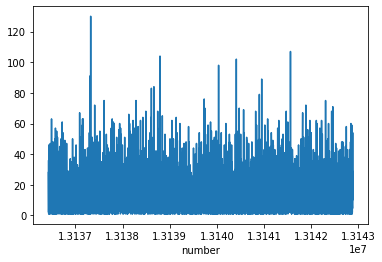

In [27]:
df['time_since_last_block'].plot()

In [165]:
merged = pd.merge(
    left=df,
    right=df,
    how='left',
    right_on='latest_avail_block',
    left_index=True,
    right_index=False,
    suffixes=('_lagged', ''),
    sort=True
)
merged = merged[merged.index.notnull()]

In [156]:
block_cols = [
    'datetime', 'lag_cutoff', 'latest_avail_block', 'difficulty_lagged', 
    'total_difficulty_lagged', 'size_lagged', 'base_fee_per_gas_lagged','datetime_lagged'
]

In [153]:
df.head(6)

,difficulty,total_difficulty,size,base_fee_per_gas,datetime,lag_cutoff,latest_avail_block,time_since_last_block
number,,,,,,,,
13136427,8409848555241209,29853078656530319963926,160051,124202762367,2021-09-01 00:00:12,2021-08-31 23:59:12,NaN,NaN
13136428,8401640107478779,29853087058170427442705,35643,139713514618,2021-09-01 00:00:40,2021-08-31 23:59:40,NaN,28.0
13136429,8405746765779804,29853095463917193222509,8983,130857526667,2021-09-01 00:00:44,2021-08-31 23:59:44,NaN,4.0
13136430,8409855429285078,29853103873772622507587,28133,115769452729,2021-09-01 00:00:46,2021-08-31 23:59:46,NaN,2.0
13136431,8413966098973704,29853112287738721481291,166713,108952304832,2021-09-01 00:00:48,2021-08-31 23:59:48,NaN,2.0
13136432,8401645248288208,29853120689383969769499,238212,122558133376,2021-09-01 00:01:24,2021-09-01 00:00:24,13136427.0,36.0


In [158]:
merged[block_cols]

,datetime,lag_cutoff,latest_avail_block,difficulty_lagged,total_difficulty_lagged,size_lagged,base_fee_per_gas_lagged,datetime_lagged
13136432.0,2021-09-01 00:01:24,2021-09-01 00:00:24,13136427.0,8409848555241209,29853078656530319963926,160051,124202762367,2021-09-01 00:00:12
13136433.0,2021-09-01 00:01:39,2021-09-01 00:00:39,13136427.0,8409848555241209,29853078656530319963926,160051,124202762367,2021-09-01 00:00:12
13136434.0,2021-09-01 00:01:40,2021-09-01 00:00:40,13136427.0,8409848555241209,29853078656530319963926,160051,124202762367,2021-09-01 00:00:12
13136435.0,2021-09-01 00:01:45,2021-09-01 00:00:45,13136429.0,8405746765779804,29853095463917193222509,8983,130857526667,2021-09-01 00:00:44
13136436.0,2021-09-01 00:02:28,2021-09-01 00:01:28,13136432.0,8401645248288208,29853120689383969769499,238212,122558133376,2021-09-01 00:01:24
...,...,...,...,...,...,...,...,...
13142877.0,2021-09-01 23:58:31,2021-09-01 23:57:31,13142873.0,8286082104421917,29906662637910091955416,155613,93741344881,2021-09-01 23:57:15
13142878.0,2021-09-01 23:58:48,2021-09-01 23:57:48,13142874.0,8282040460861664,29906670919950552817080,189732,105443136211,2021-09-01 23:57:35
13142879.0,2021-09-01 23:59:42,2021-09-01 23:58:42,13142877.0,8273965415625992,29906695741833914793168,64046,120145982304,2021-09-01 23:58:31
13142880.0,2021-09-01 23:59:49,2021-09-01 23:58:49,13142878.0,8273969710593288,29906704015803625386456,164877,118041732123,2021-09-01 23:58:48


In [118]:
df.tail()

,difficulty,total_difficulty,size,base_fee_per_gas,datetime,lag_cutoff,latest_avail_block,time_since_last_block
number,,,,,,,,
13142877,8273965415625992,29906695741833914793168,64046,120145982304,2021-09-01 23:58:31,2021-09-01 23:57:31,13142873.0,10.0
13142878,8273969710593288,29906704015803625386456,164877,118041732123,2021-09-01 23:58:48,2021-09-01 23:57:48,13142874.0,17.0
13142879,8253773884196834,29906712269577509583290,92154,131047429529,2021-09-01 23:59:42,2021-09-01 23:58:42,13142877.0,54.0
13142880,8257808342193522,29906720527385851776812,5129,129144834379,2021-09-01 23:59:49,2021-09-01 23:58:49,13142878.0,7.0
13142881,8261844770140404,29906728789230621917216,75409,114407060628,2021-09-01 23:59:54,2021-09-01 23:58:54,13142878.0,5.0


In [103]:
df['time_since_last_block'][df['time_since_last_block'] > 100]

number
13137324    130.0
13138794    104.0
13140412    102.0
13141560    107.0
Name: time_since_last_block, dtype: float64

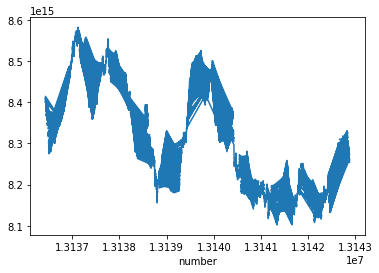

In [52]:
blocks['difficulty'].plot()

In [47]:
blocks[['difficulty', 'total_difficulty', 'size', 'base_fee_per_gas']]

,difficulty,total_difficulty,size,base_fee_per_gas
number,,,,
13136827,8382004022717228,29856415949626737747807,9146,103982045792
13136828,8386101093086241,29856424335727830834048,51582,92564314585
13136829,8382010612129179,29856432717738442963227,191522,88642962388
13136830,8382014907096475,29856441099753350059702,75696,99721942349
13136831,8390204763496481,29856449489958113556183,71934,99523189039
...,...,...,...,...
13142522,8188666131067237,29903757659963151994578,57465,103853569452
13142523,8192668798168843,29903765852631950163421,548,100853588402
13142524,8196673419697744,29903774049305369861165,84807,88246889852


In [40]:
clean_tx.head().transpose()

,0,1,2,3,4
hash,0x0c7e291fbd6c6094c53e81b116cca1a5a0ad199c10aa...,0x2567f447d63b76de7fb59e6a36af0614f3cdd6fc1e68...,0x03e5375d7ea8ea68d3c18dec32d75099a287cc232b42...,0x8a15f43c852136141e3417684284df785104adefa739...,0x20126b157dc61a5ef2af7528b4e51aca6ee79ce983e1...
block_number,13136827,13136827,13136827,13136827,13136827
transaction_index,0,1,2,3,4
from_address,0x5629eb360b54e146323f8aa34546796029bd78f6,0x1938a448d105d26c40a52a1bfe99b8ca7a745ad0,0xbccec45297ec2877ba96ae86b2fe59f95a0522e6,0x4ad64983349c49defe8d7a4686202d24b25d0ce8,0xb6d0a541e1e94a037a2b3d5e998c1272227c7b92
to_address,0x0944d5848bd9f60a34ba92aea300d4286696eb76,0xbb0e17ef65f82ab018d8edd776e8dd940327b28b,0xe000af30955d5d1f539d6ab4dfc2df499cb4f5f7,0xe7703b16ef7cd803ff46703172ef402f07a0ebb2,0x4ad64983349c49defe8d7a4686202d24b25d0ce8
value,0,0,189465600000000000,51996000000000000,249587000000000000
gas,70000,200000,50000,60000,21000
gas_price,207438875866,193619607297,163423700000,139162548391,138000000000
max_fee_per_gas,NaN,NaN,NaN,NaN,NaN
max_priority_fee_per_gas,NaN,NaN,NaN,NaN,NaN


In [20]:
lag=60

In [21]:
#sample = clean_tx.head(1000)
sample = timestamp_to_datetime(eth_data.blocks)

In [22]:
sample['lag_cutoff'] = sample['datetime'] - pd.offsets.DateOffset(seconds=lag)

In [23]:
sample['latest_avail_block'] = latest(sample, 'number', 'datetime', 'lag_cutoff')

In [24]:
lagged_cols = sample[['number', 'difficulty', 'total_difficulty', ]]

In [25]:
sample[['number', 'datetime', 'lag_cutoff', 'latest_avail_block']].sort_values(by='number').to_csv(
    'data/pit_blocks.csv', index=False
)

In [28]:
sample.set_index('number')

,hash,parent_hash,nonce,sha3_uncles,logs_bloom,transactions_root,state_root,receipts_root,miner,difficulty,total_difficulty,size,extra_data,gas_limit,gas_used,transaction_count,base_fee_per_gas,datetime,lag_cutoff,latest_avail_block
number,,,,,,,,,,,,,,,,,,,,
13136827,0x71fecf94580b6bdc8184f6799a0506d80d4c0f2df75e...,0xce7b455e4606c9937d6e30fd6f2056415cd1db8159c7...,0xfada00315b2acf50,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x10205000008000008200000080001000004000000008...,0x61649b7975e2d8c48bee823d95a2bf7fb62b5cf0530e...,0xa6708f038fcb5fa09a1bf2daaf361897d541e98c6d59...,0x718494fc38b5ab8dc3b59b8125ba647efde2f7359fbb...,0x1ad91ee08f21be3de0ba2ba6918e714da6b45836,8382004022717228,29856415949626737747807,9146,0x486976656f6e2075732d6865617679206752476e,30000000,1823420,37,103982045792,2021-09-01 01:30:18,2021-09-01 01:29:18,13136822.0
13136828,0x1524dec17ef49f415cf3aef91a7cd1b9c3d2a666b378...,0x71fecf94580b6bdc8184f6799a0506d80d4c0f2df75e...,0xc60548b2daf9e115,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x062005b2185204238e985e4c90621a165288e36bac2d...,0xc4ee29db70f290aea86c19ddb47c111d23f4deac6177...,0xd8cbb88b42bd6ea03fea267277b4472e74c592a2b7fe...,0x51950a58bc5d4b1cd5a7c18531d67fa36dd7668008e0...,0x1ad91ee08f21be3de0ba2ba6918e714da6b45836,8386101093086241,29856424335727830834048,51582,0x486976656f6e2072752d68656176792d32205545636b,30000000,9916375,163,92564314585,2021-09-01 01:30:23,2021-09-01 01:29:23,13136822.0
13136829,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,0x1524dec17ef49f415cf3aef91a7cd1b9c3d2a666b378...,0x7b4f0230fabdd5e2,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x5b6167f611830e659eb6e6d6cbeb1377f19fb47e8d71...,0x0620e0c347c6cceaed1435f0a85a95e07f33cd1de233...,0xe27a1a023bccbe0e25a5db8cf5c67489344084f9780b...,0x6d217395467b6051beb2c9eebf37b5c8a0e547c14fbf...,0x99c85bb64564d9ef9a99621301f22c9993cb89e3,8382010612129179,29856432717738442963227,191522,0x626565706f6f6c2e6f72675f3600dc,30029295,30027410,365,88642962388,2021-09-01 01:30:49,2021-09-01 01:29:49,13136824.0
13136830,0x54f8b2ff071ae26f2f2378b10342c9808ab5d4856cc0...,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,0xef0304be9234d448,0x1818ae7a3c41d975b75ab24ff062320b7e364abc2edf...,0x1021210adbe1526770a4a16ab331e001c7239c268c1e...,0x85d7724309935219ccbdfe020910c79f6aa3a00c2c58...,0x12c2d47e3a18d492fc61fdf2d3447982d9d5658ccbab...,0x6db55497811e47ea4269f1d02af20e11215c75433dd7...,0x00192fb10df37c9fb26829eb2cc623cd1bf599e8,8382014907096475,29856441099753350059702,75696,0x457468657265756d50504c4e532f326d696e6572735f...,30000000,14760831,121,99721942349,2021-09-01 01:30:58,2021-09-01 01:29:58,13136824.0
13136831,0xd424d29dfaf400377be554adbc5254b12ce94e192c09...,0x54f8b2ff071ae26f2f2378b10342c9808ab5d4856cc0...,0x8dea8fa1a802c647,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x15a0c0726d0019999085ab60a2320f0912021a004a41...,0x62a01c65c2206282d10d14b4a6acc7c775c3e9668cfd...,0xdd3445c528cbf062b9c449018883a2dd1143cf58741a...,0x8c640d527d3eac280ec2a2ec74979557b5c08f445223...,0xe206e3dca498258f1b7eec1c640b5aee7bb88fd0,8390204763496481,29856449489958113556183,71934,0xd883010a08846765746888676f312e31362e37856c69...,30000000,13709421,136,99523189039,2021-09-01 01:31:01,2021-09-01 01:30:01,13136826.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13142522,0x7da93020043328ff546d125c6ce2dc43331f122e8d46...,0x31d550609039cb035671526421f8a8e71c3630dd8834...,0xad6d2b05ff4b0e8e,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x182c409221261393d08c30c2b0234e0d348250c51e8c...,0x3f62bd4a325ad6cdb4ddfe00e57f9d131d6931de9afa...,0xd2dbcc3a01966799aad514abaac0b3791cbb48572f99...,0x4a40f0d02156cd6945b5cc450b3558ea9395d8c094fe...,0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c,8188666131067237,29903757659963151994578,57465,0xd883010a08846765746888676f312e31362e37856c69...,29999972,11533592,108,103853569452,2021-09-01 22:43:49,2021-09-01 22:42:49,13142518.0
13142523,0x2ce0bba1430ed4d259c3b1410d31ee3385a3a58d137d...,0x7da93

In [247]:
clean_tx.columns

Index(['hash', 'block_number', 'transaction_index', 'from_address',
       'to_address', 'value', 'gas', 'gas_price', 'max_fee_per_gas',
       'max_priority_fee_per_gas', 'transaction_type', 'transaction_hash',
       'cumulative_gas_used', 'gas_used', 'contract_address', 'status',
       'effective_gas_price', 'token_address', 'from_address_transfer',
       'to_address_transfer', 'value_transfer', 'transaction_hash_transfer',
       'log_index', 'block_number_transfer', 'address', 'function_sighashes',
       'is_erc20', 'is_erc721', 'block_number_to_contract',
       'address_from_contract', 'function_sighashes_from_contract',
       'is_erc20_from_contract', 'is_erc721_from_contract',
       'block_number_from_contract', 'number', 'miner', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used_block',
       'transaction_count', 'base_fee_per_gas', 'datetime', 'is_vanilla'],
      dtype='object')

In [255]:
eth_data.transactions[eth_data.transactions['hash'] == hash_]

,hash,nonce,block_hash,block_number,transaction_index,from_address,to_address,value,gas,gas_price,input,block_timestamp,max_fee_per_gas,max_priority_fee_per_gas,transaction_type
1445,0x080228f5ab4ae374d7dcce11c6b1a7812e6a05f2ba6a...,74,0xf822c5615ec5a3cd18a3f5771d618b9e5084289715c1...,13136835,189,0xcd7f43bebae54f92a236a079a212e6ec7eaa2332,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,60000000000000000,316703,95325552434,0xab834bab0000000000000000000000007be8076f4ea4...,1630459894,1.015946e+11,1.325400e+09,2


In [258]:
eth_data.logs['topics'][0]

'0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef,0x0000000000000000000000003b9665d11f4284d77d7833a1efd4c0f8480ece9b,0x000000000000000000000000155b5ca45861a1b60fdef9a54325f59b8c6610ca'

In [256]:
eth_data.logs[eth_data.logs['transaction_hash'] == hash_]

,log_index,transaction_hash,transaction_index,block_hash,block_number,address,data,topics
2271,295,0x080228f5ab4ae374d7dcce11c6b1a7812e6a05f2ba6a...,189,0xf822c5615ec5a3cd18a3f5771d618b9e5084289715c1...,13136835,0xbe1014903e2f623a88e4413e276fb176e6e832de,0x,0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2...
2272,296,0x080228f5ab4ae374d7dcce11c6b1a7812e6a05f2ba6a...,189,0xf822c5615ec5a3cd18a3f5771d618b9e5084289715c1...,13136835,0xbe1014903e2f623a88e4413e276fb176e6e832de,0x,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...
2273,297,0x080228f5ab4ae374d7dcce11c6b1a7812e6a05f2ba6a...,189,0xf822c5615ec5a3cd18a3f5771d618b9e5084289715c1...,13136835,0x7be8076f4ea4a4ad08075c2508e481d6c946d12b,0x00000000000000000000000000000000000000000000...,0xc4109843e0b7d514e4c093114b863f8e7d8d9a458c37...


In [254]:
hash_ = eth_data.token_transfers.loc[1000,'transaction_hash']

In [252]:
eth_data.token_transfers.loc[1000,]

token_address              0xbe1014903e2f623a88e4413e276fb176e6e832de
from_address               0x71e7b94490837ccaf45f9f6c7c20a3e17bbeb7d3
to_address                 0xcd7f43bebae54f92a236a079a212e6ec7eaa2332
value                                                            5602
transaction_hash    0x080228f5ab4ae374d7dcce11c6b1a7812e6a05f2ba6a...
log_index                                                         296
block_number                                                 13136835
Name: 1000, dtype: object

In [80]:
features = pd.DataFrame(index=clean_tx.index)

In [30]:
clean_tx['is_vanilla'] = clean_tx['gas_used'] == 21000

In [250]:
features.tail()

,base_fee_per_gas_lagged_10,base_fee_per_gas_lagged_20,base_fee_per_gas_lagged_50,base_fee_per_gas_lagged_100,base_fee_per_gas_lagged_10,base_fee_per_gas_lagged_20,base_fee_per_gas_lagged_50,base_fee_per_gas_lagged_100,block_number,base_fee_per_gas_chg_10,...,base_fee_per_gas_chg_100,base_fee_per_gas_lagged_10,base_fee_per_gas_lagged_20,base_fee_per_gas_lagged_50,base_fee_per_gas_lagged_100,base_fee_per_gas_chg_10,base_fee_per_gas_chg_20,base_fee_per_gas_chg_50,base_fee_per_gas_chg_100,transaction_hash
1516733,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,13142526,-0.158252,...,-0.078566,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,-0.158252,-0.22646,-0.149085,-0.078566,0xcda96b118bfd79387a111608f32949d7c42780f18244...
1516734,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,13142526,-0.158252,...,-0.078566,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,-0.158252,-0.22646,-0.149085,-0.078566,0xf8f0e8e45d85017db4d0a6e43fa4bd625b9701a709ea...
1516735,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,13142526,-0.158252,...,-0.078566,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,-0.158252,-0.22646,-0.149085,-0.078566,0x9bd9e5731408131fbb5cb30b8bf06a08b4921a5268a0...
1516736,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,13142526,-0.158252,...,-0.078566,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,-0.158252,-0.22646,-0.149085,-0.078566,0xfafa9664c01697e4fbd9ba7c1391f5f6761be5e78d2b...
1516737,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,13142526,-0.158252,...,-0.078566,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,-0.158252,-0.22646,-0.149085,-0.078566,0x0ee19f9da24958d2850c33e4efd7cd95fd1fdccedb6d...


### base_fee_per_gas

In [44]:
block_base_fee = clean_tx[['datetime', 'base_fee_per_gas']].groupby('datetime').last()

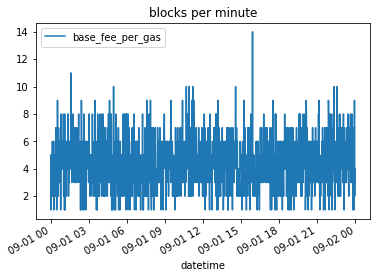

In [117]:
# average number of blocks per minute
mean_blocks_per_min = block_base_fee.groupby(block_base_fee.index.floor('Min')).count()
mean_blocks_per_min.plot(title="blocks per minute");

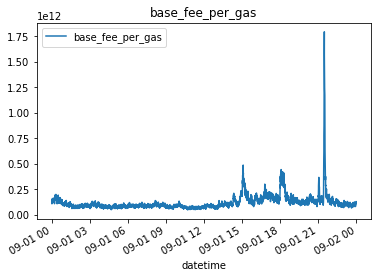

In [47]:
block_base_fee.plot(title="base_fee_per_gas");

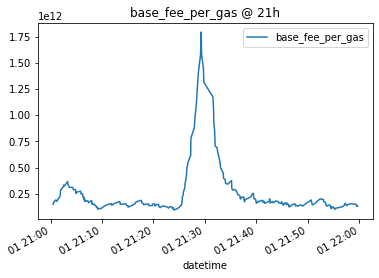

In [52]:
block_base_fee[block_base_fee.index.hour == 21].plot(title="base_fee_per_gas @ 21h");

In [76]:
block_base_fee_lead_lag = lead_lag(block_base_fee, block_base_fee, range(0, 500))

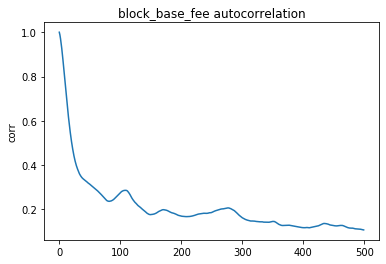

In [79]:
ax = block_base_fee_lead_lag.plot(
    title="block_base_fee autocorrelation"
)

ax.set_label('lag')
ax.set_ylabel('corr');

In [122]:
block_base_fee.corrwith(block_base_fee.shift(100))

base_fee_per_gas    0.275699
dtype: float64

In [238]:
blocks_df = eth_data.blocks[['number', 'base_fee_per_gas']].set_index('number')
lagged_base_fee = pd.DataFrame({
    f"base_fee_per_gas_lagged_{str(i)}" : blocks_df['base_fee_per_gas'].shift(i) 
    for i in feature_block_lags
})
lagged_base_fee.index = blocks_df.index

features = pd.concat([
    features,
    pd.merge(
        clean_tx[['block_number']], 
        lagged_base_fee, 
        how='left',
        left_on='block_number',
        right_index=True
    ).filter(like='lagged')
], axis=1)

In [213]:
features.tail()

,base_fee_per_gas_lagged_10,base_fee_per_gas_lagged_20,base_fee_per_gas_lagged_50,base_fee_per_gas_lagged_100,base_fee_per_gas_lagged_10,base_fee_per_gas_lagged_20,base_fee_per_gas_lagged_50,base_fee_per_gas_lagged_100
1516733,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10
1516734,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10
1516735,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10
1516736,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10
1516737,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10,9.649266e+10,1.025794e+11,8.841796e+10,8.186496e+10


In [215]:
#blocks_df

In [160]:
feature_block_lags

[10, 20, 50, 100]

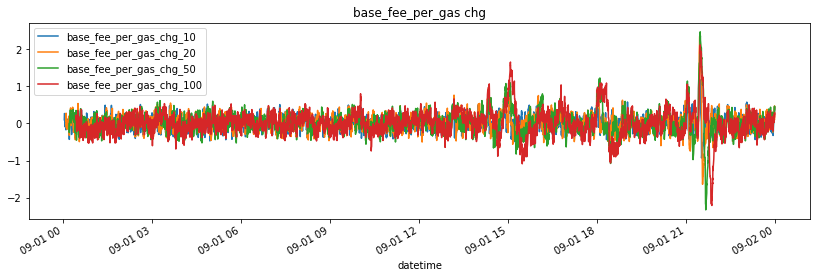

In [231]:
chg_df = clean_tx[['block_number', 'datetime', 'base_fee_per_gas']].groupby('datetime').mean()
srs = chg_df['base_fee_per_gas']
block_base_fee_ma = pd.DataFrame({
    f"base_fee_per_gas_chg_{k}" : np.log(srs / srs.shift(k)) for k in feature_block_lags
})
block_base_fee_ma.plot(title="base_fee_per_gas chg",figsize=(14, 4));
block_base_fee_ma.index = chg_df['block_number']

In [239]:
features = pd.concat([
    features,
    pd.merge(
        clean_tx[['block_number']], 
        block_base_fee_ma, 
        how='left',
        left_on='block_number',
        right_index=True
    ).filter(like='chg')
], axis=1)

In [244]:
features['transaction_hash'] = clean_tx['hash']

In [245]:
features.to_csv('data/features.csv')

In [241]:
#features.tail()

In [ ]:
# is_vanilla if gas_used = 21000

In [19]:
clean_tx.columns

Index(['hash', 'block_number', 'transaction_index', 'from_address',
       'to_address', 'value', 'gas', 'gas_price', 'max_fee_per_gas',
       'max_priority_fee_per_gas', 'transaction_type', 'transaction_hash',
       'cumulative_gas_used', 'gas_used', 'contract_address', 'status',
       'effective_gas_price', 'token_address', 'from_address_transfer',
       'to_address_transfer', 'value_transfer', 'transaction_hash_transfer',
       'log_index', 'block_number_transfer', 'address', 'function_sighashes',
       'is_erc20', 'is_erc721', 'block_number_to_contract',
       'address_from_contract', 'function_sighashes_from_contract',
       'is_erc20_from_contract', 'is_erc721_from_contract',
       'block_number_from_contract', 'number', 'miner', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used_block',
       'transaction_count', 'base_fee_per_gas', 'datetime'],
      dtype='object')

In [39]:
# plt.scatter(
#     clean_tx[['datetime', 'is_vanilla']].groupby('datetime').mean(),
#     clean_tx[['datetime', 'gas_used']].groupby('datetime').mean()
# )

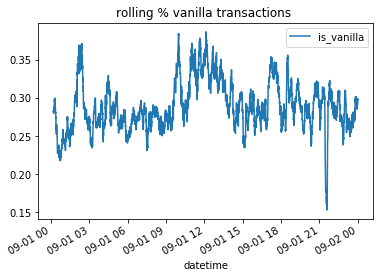

In [38]:
clean_tx[['datetime', 'is_vanilla']].groupby('datetime').mean().rolling(50).mean().plot(
    title="rolling % vanilla transactions "
);

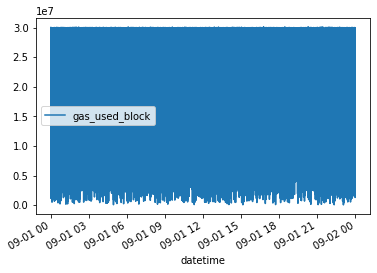

In [27]:
clean_tx[['datetime', 'gas_used_block']].groupby('datetime').mean().plot()

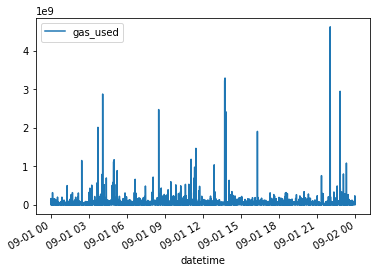

In [23]:
clean_tx[['datetime', 'gas_used']].groupby('datetime').sum().plot()

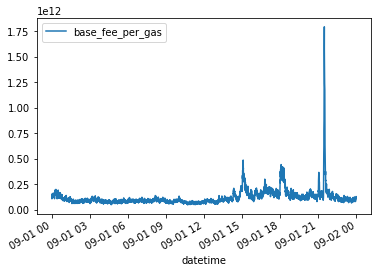

In [10]:
clean_tx[['datetime', 'base_fee_per_gas']].groupby('datetime').mean().plot()

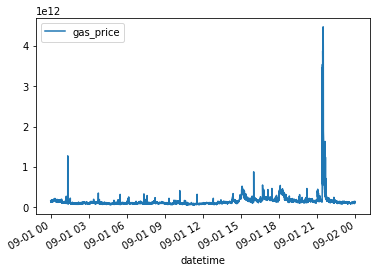

In [11]:
clean_tx[['datetime', 'gas_price']].groupby('datetime').mean().plot()

In [13]:
clean_tx.columns

Index(['hash', 'block_number', 'transaction_index', 'from_address',
       'to_address', 'value', 'gas', 'gas_price', 'max_fee_per_gas',
       'max_priority_fee_per_gas', 'transaction_type', 'transaction_hash',
       'cumulative_gas_used', 'gas_used', 'contract_address', 'status',
       'effective_gas_price', 'token_address', 'from_address_transfer',
       'to_address_transfer', 'value_transfer', 'transaction_hash_transfer',
       'log_index', 'block_number_transfer', 'address', 'function_sighashes',
       'is_erc20', 'is_erc721', 'block_number_to_contract',
       'address_from_contract', 'function_sighashes_from_contract',
       'is_erc20_from_contract', 'is_erc721_from_contract',
       'block_number_from_contract', 'number', 'miner', 'difficulty',
       'total_difficulty', 'size', 'gas_limit', 'gas_used_block',
       'transaction_count', 'base_fee_per_gas', 'datetime'],
      dtype='object')

In [ ]:
clean_tx[['datetime', 'gas_price']].groupby('datetime').mean().plot()